In [1]:
from brian2 import *


prefs.codegen.target = "numpy"

# Важно! 

Я же неправильно начальные условия для воротных переменых указал, это может быть проблемой для возникновения спайка от короткого но высокоамплитудного тока!

## Минимальный набор

$$
\begin{cases}
\alpha_n = 0.032 \frac{15 - v + v_T}{\exp(\frac{15 - v + v_T}{5}) - 1} \\
\beta_n = 0.5 \exp(\frac{10 - v + v_T}{40}) \\
\alpha_m = 0.32 \frac{13 - v + v_T}{\exp(\frac{13 - v + v_T}{4}) - 1} \\
\beta_m = 0.28 \frac{v - v_T - 40}{\exp(\frac{v - v_T - 40}{5}) - 1} \\
\alpha_h = 0.128 \exp(\frac{17 - v + v_T}{18}) \\
\beta_h = \frac{4}{1 + \exp(\frac{40 - v + v_T}{5})}
\end{cases}
$$

In [2]:
start_scope()

Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brian examples

eqs = Equations("""
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I) / Cm : volt

I : ampere
""")

dndt = Equations("""
dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz
    """)
dmdt = Equations("""
dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
""")
dhdt = Equations("""
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz
""")
min_eqs = eqs+dndt+dmdt+dhdt
neuron = NeuronGroup(1, min_eqs, method='euler')

stmon = StateMonitor(neuron, ['v', 'h', 'm', 'n'], True)

neuron.v = El

store("init")

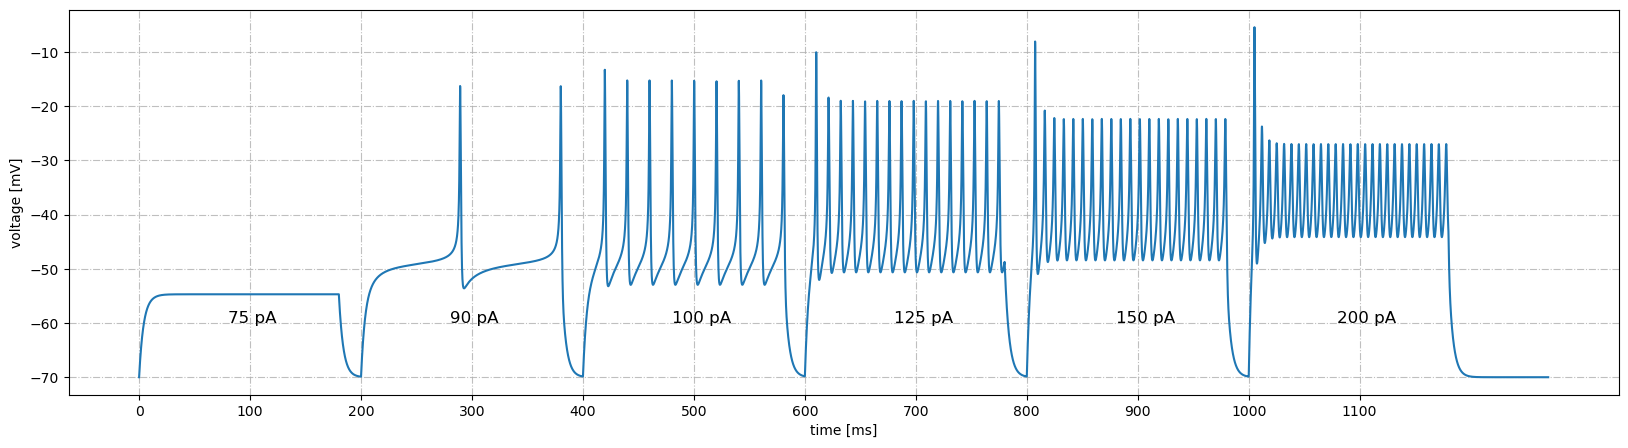

In [3]:
restore("init")

currs = [75, 90, 100, 125, 150, 200]

for i in currs:
    neuron.I = i * pA
    run(180*ms)
    neuron.I = 0 * pA
    run(20*ms)

run(70*ms)

figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV)
ylabel("voltage [mV]")
xlabel("time [ms]")
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("basic_spikes.jpeg", dpi=200)

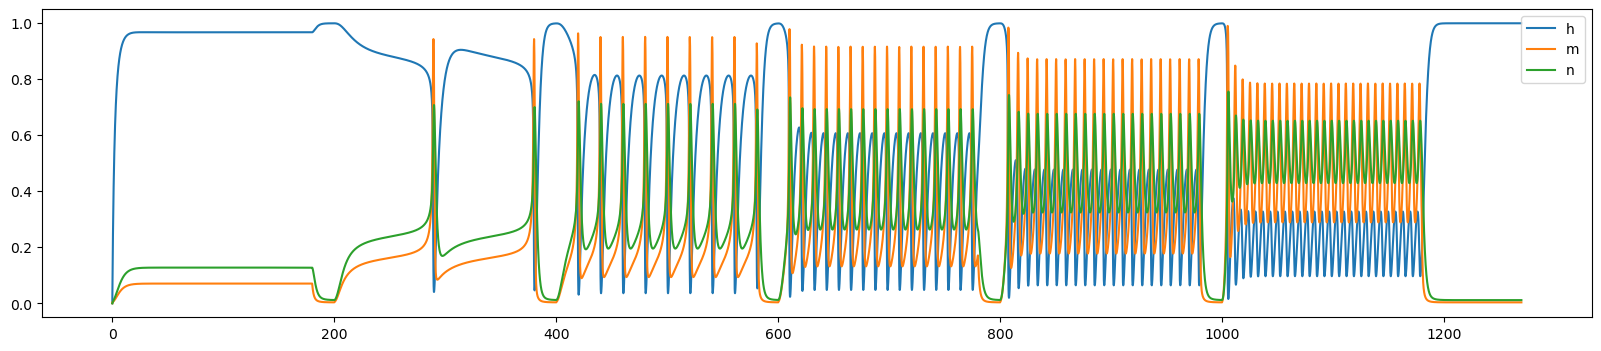

In [4]:
figure(figsize=(20, 4))
plot(stmon.t/ms, stmon.h[0])
plot(stmon.t/ms, stmon.m[0])
plot(stmon.t/ms, stmon.n[0])
legend(["h", "m", "n"])

#### Каналы вцелом (не ворота по отдельности).

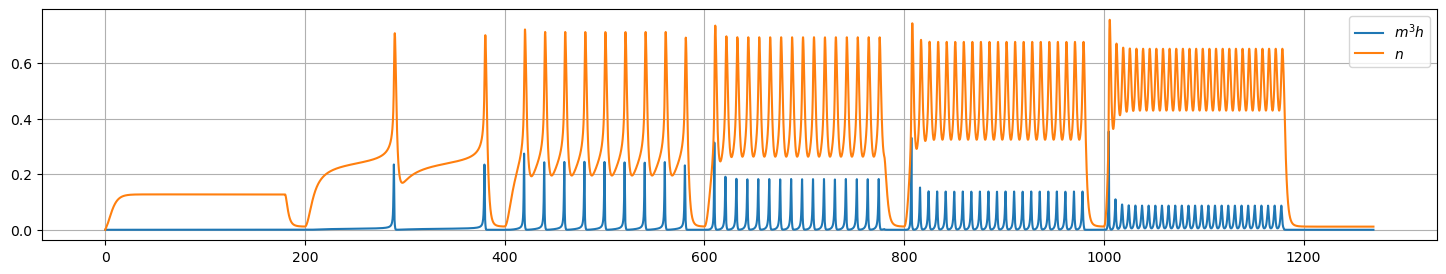

In [5]:
figure(figsize=(18,3))
plot(stmon.t/ms, stmon.m[0]**3 * stmon.h[0], label="$m^3h$")
plot(stmon.t/ms, stmon.n[0], label="$n$")
legend()
grid()

# Синапсы

## Просто синапс (один к одному)

In [41]:
start_scope()

Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 0.5 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(2, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=0, j=1)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0] = i * pA
    run(180*ms)
    neuron.I[0] = 0 * pA
    run(20*ms)

run(70*ms)

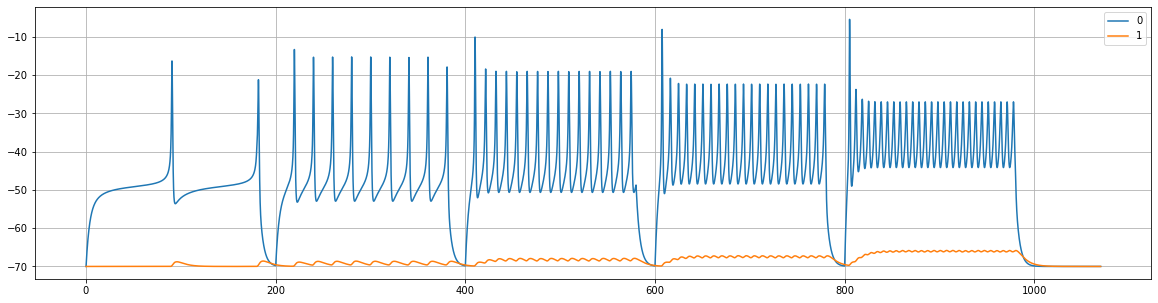

In [27]:
figure(figsize=(20, 5))
plot(stmon.t/ms, stmon.v[0]/mV, label='0')
plot(stmon.t/ms, stmon.v[1]/mV, label='1')
grid()
legend()

## Несколько нейронов к одному

In [8]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 0.5 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(11, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=range(0, 10), j=10)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0:11] = i * pA
    run(180*ms)
    neuron.I[0:11] = 0 * pA
    run(20*ms)

run(70*ms)

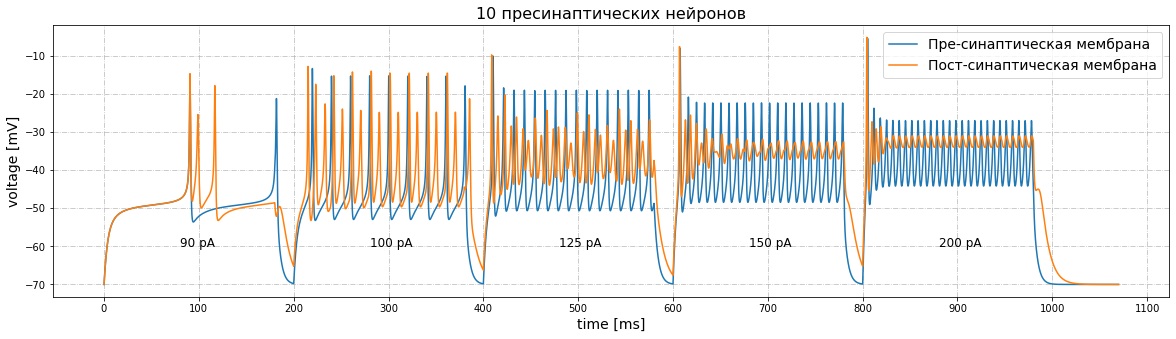

In [9]:
figure(figsize=(20, 5))
title("10 пресинаптических нейронов", fontsize=16)
plot(stmon.t/ms, stmon.v[0]/mV, label='Пре-синаптическая мембрана')
plot(stmon.t/ms, stmon.v[10]/mV, label='Пост-синаптическая мембрана')
grid()
legend(fontsize=14)
ylabel("voltage [mV]", fontsize=14)
xlabel("time [ms]", fontsize=14)
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("десять_к_одному.jpeg", dpi=200)

## Один к одному, много нейротрансмиттера

In [4]:
Cm = 20 * pF
Ena = 55 * mV
Ek = -85 * mV
El = -70 * mV
gK = 40 * nS
gL = 5 * nS
gNa = 50 * nS

VT = -63 * mV  # from brain examples

syn_w = 10 * pA
tau_s = 7.5 * ms

eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

neuron = NeuronGroup(2, eqs, method='euler', threshold='v > -40*mV', reset='')
stmon = StateMonitor(neuron, ['v'], True)
neuron.v = El

syns = Synapses(neuron, neuron, on_pre='Isyn += syn_w')
syns.connect(i=0, j=1)

currs = [90, 100, 125, 150, 200]

for i in currs:
    neuron.I[0:11] = i * pA
    run(180*ms)
    neuron.I[0:11] = 0 * pA
    run(20*ms)

run(70*ms)

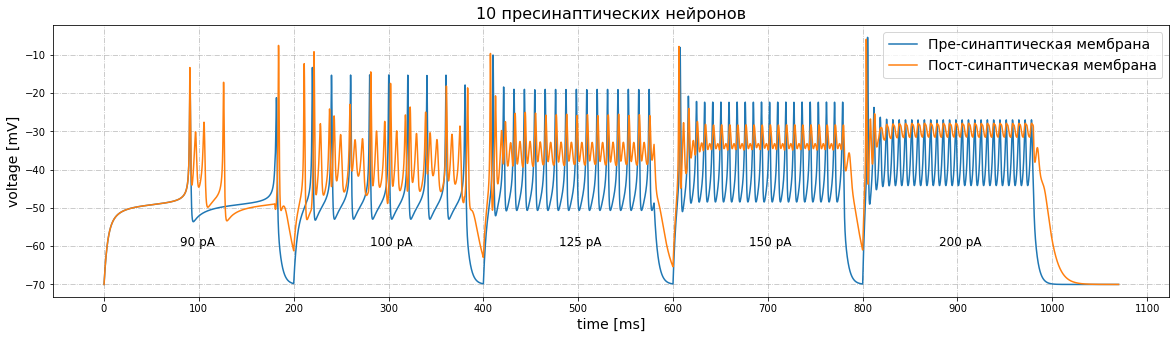

In [5]:
figure(figsize=(20, 5))
title("10 пресинаптических нейронов", fontsize=16)
plot(stmon.t/ms, stmon.v[0]/mV, label='Пре-синаптическая мембрана')
plot(stmon.t/ms, stmon.v[1]/mV, label='Пост-синаптическая мембрана')
grid()
legend(fontsize=14)
ylabel("voltage [mV]", fontsize=14)
xlabel("time [ms]", fontsize=14)
xticks(ticks=range(0, 1200, 100))
grid(alpha=.8, ls='-.')
for i, cur in enumerate(currs):
    text(200*i+80, -60, f"{cur} pA", fontsize=12)
#savefig("один_к_одному.jpeg", dpi=200)

# Подпороговая активность

Мы хотим сделать её более плавной, не такой резкой. Чтобы было похоже на экспериментальные данные.

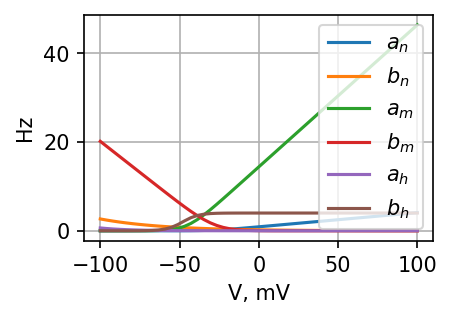

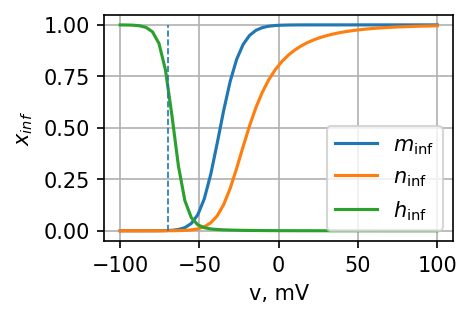

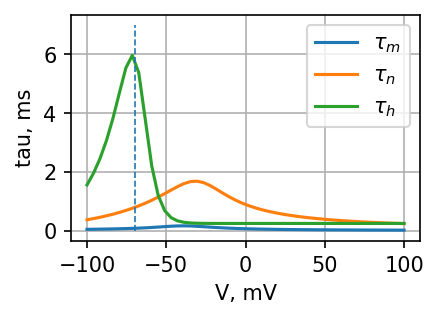

In [9]:
vv = np.linspace(-100, 100)
VT_ = -63 
an = 0.032 * 5 / exprel((15 - vv + VT_ +20)/5)  # remove +20
bn = 0.5 * exp((10 - vv + VT_ +20)/40)
n_inf = an / (an + bn)
tau_n = 1 / (an + bn)

am = 0.32 * 4 / exprel((13 - vv + VT_ +5)/4)  # remove -15
bm = 0.28 * 5 / exprel((vv - VT_ - 40 +5)/5)  # remove -15
m_inf = am / (am + bm)
tau_m = 1 / (am + bm)

ah = 0.128*exp((17 - vv + VT_ -25)/18)  # remove -15
bh = 4 / (1 + exp((40 - vv + VT_ -25)/5))  # remove -15
h_inf = ah / (ah + bh)
tau_h = 1 / (ah + bh)

figure(figsize=(3,2), dpi=150)
plot(vv, an, label='$a_n$')
plot(vv, bn, label='$b_n$')
plot(vv, am, label='$a_m$')
plot(vv, bm, label='$b_m$')
plot(vv, ah, label='$a_h$')
plot(vv, bh, label='$b_h$')
grid()
ylabel('Hz')
xlabel('V, mV')
legend()

figure(figsize=(3,2), dpi=150)
plot(vv, m_inf, label='$m_{\inf}$')
plot(vv, n_inf, label='$n_{\inf}$')
plot(vv, h_inf, label='$h_{\inf}$')
vlines(-70, 0, 1, ls="--", lw=.8)
grid()
ylabel("$x_{inf}$")
xlabel("v, mV")
legend();

figure(figsize=(3,2), dpi=150)
plot(vv, tau_m)
plot(vv, tau_n)
plot(vv, tau_h)
grid()
vlines(-70, 0, 7, ls="--", lw=.8)
ylabel('tau, ms')
xlabel('V, mV')
legend([f"$\\tau_{x}$" for x in ['m', 'n', 'h']]);

In [10]:
start_scope()
Cm = 20*pF

test_eqs = """
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I + Isyn) / Cm : volt

#dn/dt = a_n * (1 - n) - b_n * n : 1
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz

dn/dt = -(n - n0) / tau_n : 1
n0 = a_n / (a_n + b_n) : 1
tau_n = 1 / (a_n + b_n) : second

dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz

#dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz
dh/dt = -(h - h0) / tau_h : 1
h0 = a_h / (a_h + b_h) : 1
tau_h = 1 / (a_h + b_h) + 3*ms : second

dIsyn/dt = -Isyn/tau_s : ampere

I : ampere
"""

test = NeuronGroup(1, test_eqs, method='euler')  # modified
#test = NeuronGroup(1, eqs, method='euler')
testmon = StateMonitor(test, ['v', 'n', 'm', 'h', 'tau_n'], True)  # modified
#testmon = StateMonitor(test, ['v', 'n', 'm', 'h'], True)

test.v = El

for j in [120, 200]*pA:
    test.I = j
    run(30*ms)
    test.I = 0*pA
    run(20*ms)

BrianObjectException: Error encountered with object named 'neurongroup_2'.
Object was created here (most recent call only, full details in debug log):
  File '/var/folders/dk/88m9s1b50v53bxqm50d17bjm0000gn/T/ipykernel_4326/686785842.py', line 31, in <cell line: 31>
    test = NeuronGroup(1, test_eqs, method='euler')  # modified

An error occurred when preparing an object. (See above for original error message and traceback.)

$$ \tau = \frac{1}{\alpha + \beta} $$

$$ \tau + 5ms = \frac{1}{\alpha + \beta} + 5ms = \frac{1}{\alpha^{'} + \beta^{'}} $$

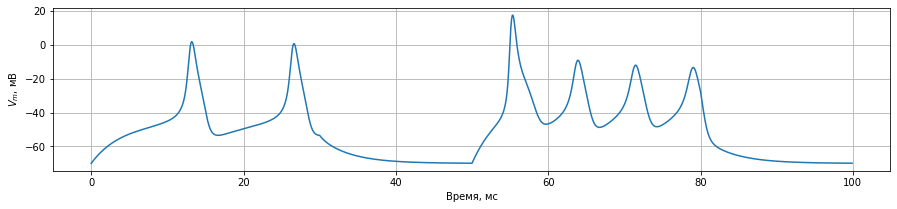

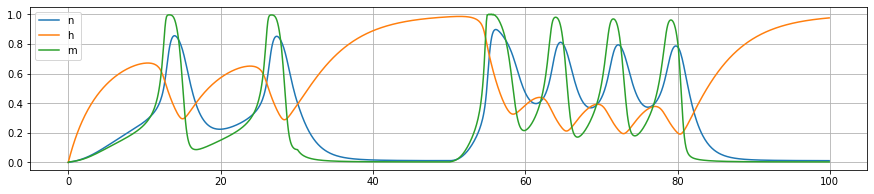

In [14]:
# modified, 
figure(figsize=(15, 3))
plot(testmon.t/ms, testmon.v[0]/mV)
grid()
xlabel("Время, мс")
ylabel("$V_m$, мВ")
#savefig("modified_initial.jpg", dpi=150)
figure(figsize=(15,3))
plot(testmon.t/ms, testmon.n[0], label='n')
plot(testmon.t/ms, testmon.h[0], label='h')
plot(testmon.t/ms, testmon.m[0], label='m')
grid()
legend()

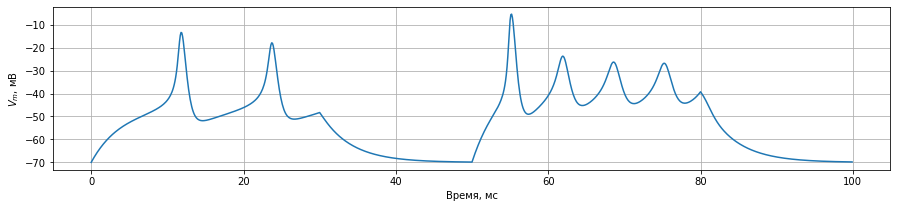

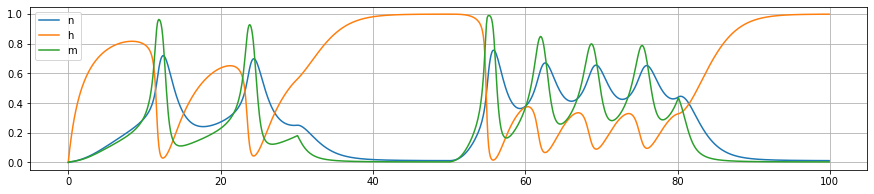

In [18]:
# unmodified
figure(figsize=(15, 3))
plot(testmon.t/ms, testmon.v[0]/mV)
grid()
xlabel("Время, мс")
ylabel("$V_m$, мВ")
#savefig("un_modified_initial.jpg", dpi=150)
figure(figsize=(15,3))
plot(testmon.t/ms, testmon.n[0], label='n')
plot(testmon.t/ms, testmon.h[0], label='h')
plot(testmon.t/ms, testmon.m[0], label='m')
grid()
legend()

## Увеличиваем утечку
Главная идея - мы изменяем проводимость "каналов" утечки. Смотрим, как стимул-ответ кривая поведёт себя.

In [11]:
start_scope()

highgEl = 7.5 * nS

highEl_group = NeuronGroup(1, min_eqs, method="euler", namespace={"gL": highgEl})

highEl_mon = StateMonitor(highEl_group, ['v'], True)
highEl_group.v = El

store("highEl_init")

In [12]:
%%time
restore("highEl_init")
for cur in [100, 150, 200, 250]:
    run(20*ms)
    highEl_group.I = cur * pA
    run(500*ms)
    highEl_group.I = 0*pA

WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_3". Will use the object from the group-specific namespace with the value 7.5 * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


CPU times: user 9.03 s, sys: 118 ms, total: 9.15 s
Wall time: 9.27 s


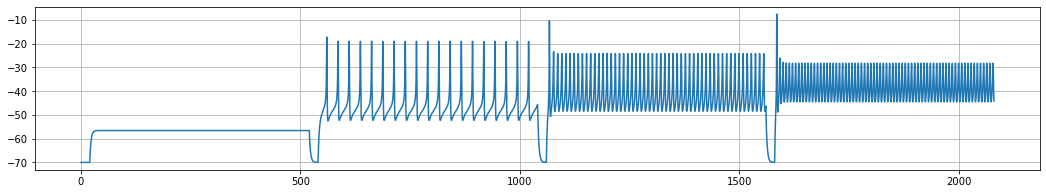

In [73]:
figure(figsize=(18,3))
plot(highEl_mon.t/ms, highEl_mon.v[0]/mV)
grid()

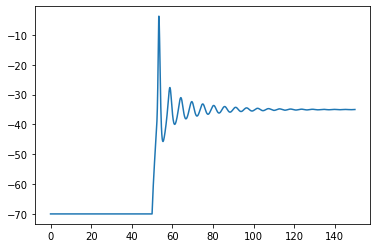

In [69]:
restore("highEl_init")
run(50*ms)
highEl_group.I = 350*pA
run(100*ms)
plot(highEl_mon.t/ms, highEl_mon.v[0]/mV)

# Зависимость частоты от входящего тока

In [4]:
threshold_str = "v > -40*mV"
refractory_str = "v > -40*mV"

def compIFcurve(group, max_cur=240, N=100):  # arg N is redundant
    mon = SpikeMonitor(group)
    group.v = -70*mV
    group.I = f"i * {max_cur}*pA / N"
    run(2000*ms)
    return mon

def plotIFcurve(mon, group):
    plot(group.I/pA, mon.count/2, "--o", lw=1, ms=4)
    xlabel("Входящий ток, пА")
    ylabel("Частота, Гц")
    grid(True)

## Модель, изначальная (минимальный набор)

WARNING    'i' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


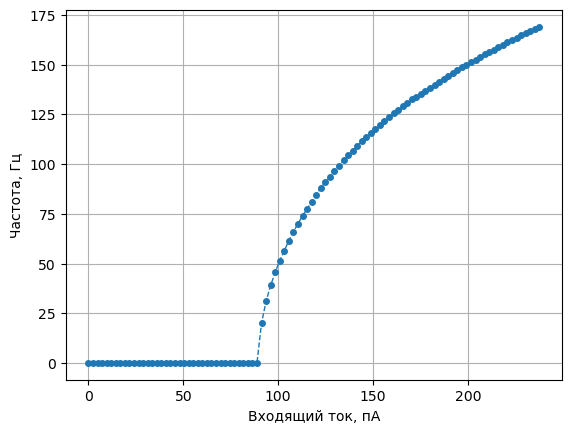

In [5]:
start_scope()
N_min=100
if_min_group = NeuronGroup(N_min, min_eqs, method="euler", threshold=threshold_str, refractory=refractory_str)

min_mon = compIFcurve(if_min_group)
plotIFcurve(min_mon, if_min_group)

In [6]:
if_min_group.I

<neurongroup_1.I: array([  0. ,   2.4,   4.8,   7.2,   9.6,  12. ,  14.4,  16.8,  19.2,
        21.6,  24. ,  26.4,  28.8,  31.2,  33.6,  36. ,  38.4,  40.8,
        43.2,  45.6,  48. ,  50.4,  52.8,  55.2,  57.6,  60. ,  62.4,
        64.8,  67.2,  69.6,  72. ,  74.4,  76.8,  79.2,  81.6,  84. ,
        86.4,  88.8,  91.2,  93.6,  96. ,  98.4, 100.8, 103.2, 105.6,
       108. , 110.4, 112.8, 115.2, 117.6, 120. , 122.4, 124.8, 127.2,
       129.6, 132. , 134.4, 136.8, 139.2, 141.6, 144. , 146.4, 148.8,
       151.2, 153.6, 156. , 158.4, 160.8, 163.2, 165.6, 168. , 170.4,
       172.8, 175.2, 177.6, 180. , 182.4, 184.8, 187.2, 189.6, 192. ,
       194.4, 196.8, 199.2, 201.6, 204. , 206.4, 208.8, 211.2, 213.6,
       216. , 218.4, 220.8, 223.2, 225.6, 228. , 230.4, 232.8, 235.2,
       237.6]) * pamp>

In [7]:
min_mon.count/2

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,  20. ,  31. ,  39. ,  45.5,  51.5,  56.5,  61.5,
        66. ,  70. ,  74. ,  77.5,  81. ,  84.5,  88. ,  91. ,  93.5,
        96.5,  99. , 102. , 104.5, 106.5, 109. , 111.5, 113.5, 115.5,
       117.5, 119.5, 121.5, 123.5, 125.5, 127. , 129. , 130.5, 132.5,
       134. , 135.5, 137. , 138.5, 140. , 141.5, 143. , 144.5, 146. ,
       147.5, 149. , 150. , 151.5, 152.5, 154. , 155.5, 156.5, 157.5,
       159. , 160. , 161.5, 162.5, 163.5, 165. , 166. , 167. , 168. ,
       169. ])

In [8]:
if_min_frequencies = min_mon.count/2

## Модель, попытка "снизить подпороговую активность"

`NeuronGroup(..., test_eqs, ...)`

In [10]:
start_scope()
N_if = 100
if_group = NeuronGroup(N_if, test_eqs, method="euler", threshold=threshold_str, refractory=refractory_str)
test_mon = compIFcurve(if_group)
plotIFcurve(test_mon, if_group)

NameError: name 'test_eqs' is not defined

## Модель, повышение утечки

WARNING    'N' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 200. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 7.5 * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


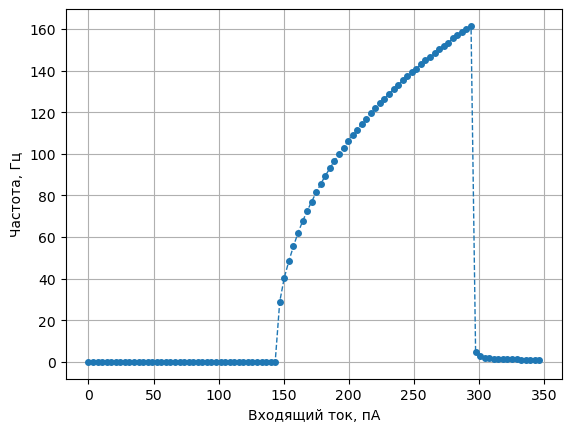

In [8]:
start_scope()
highgl = 7.5*nS
highEl_group = NeuronGroup(N, min_eqs, method="euler", namespace={"gL": highgl},
                           threshold=threshold_str, refractory=refractory_str)
highEl_mon = compIFcurve(highEl_group, N=200, max_cur=350)
plotIFcurve(highEl_mon, highEl_group)

# Влияние Nav1.8 каналов

## А как формируется кривая "стимул-ответ"?

### исследуем область, в которой происходит переход (в область "отрицательного ускорения")

In [133]:
start_scope()
min_neuron = NeuronGroup(1, min_eqs, method='euler')
min_mon = StateMonitor(min_neuron, ["v", "n", "m", "h"], 0)
min_neuron.v = -70*mV
store("min_test_init")

In [134]:
# 100 - 150pA
restore("min_test_init")
currents = np.arange(100.8, 160, 2.4*5) * pA
for cur in currents:
    run(20*ms)
    min_neuron.I = cur
    run(200*ms)
    min_neuron.I = 0*pA

In [103]:
100.8 / 2.4

42.0

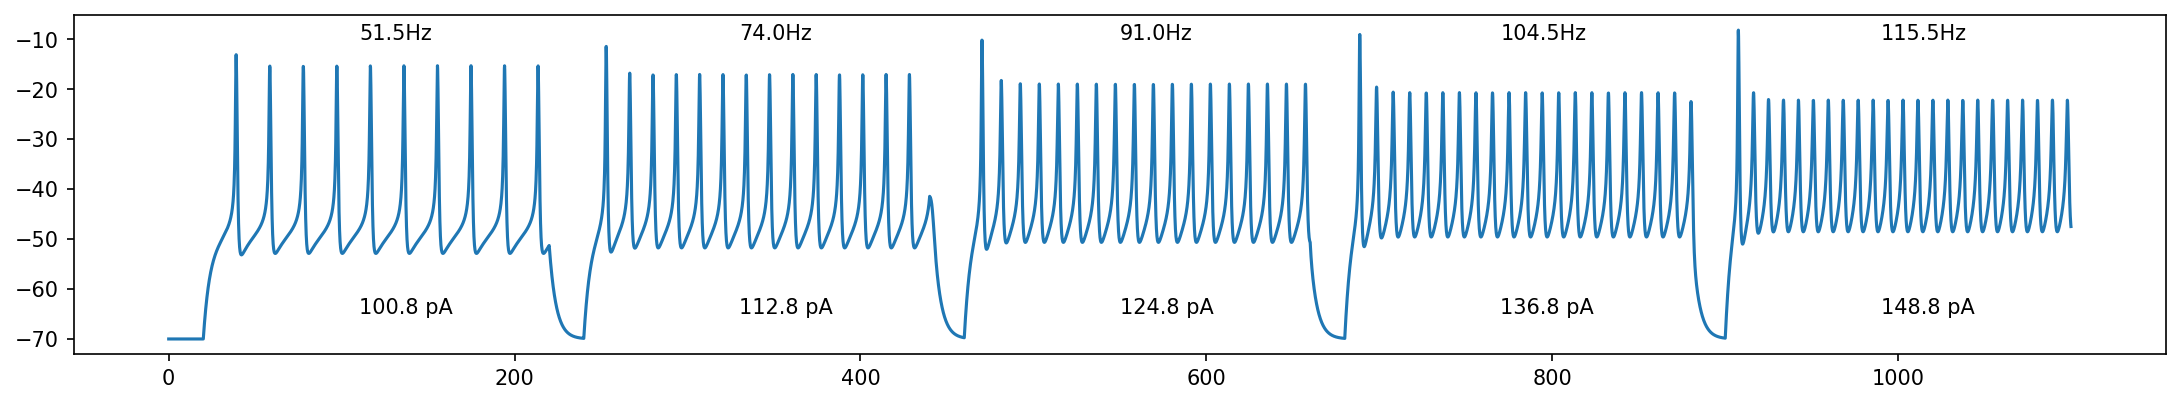

In [148]:
figure(figsize=(18,3), dpi=150)
plot(min_mon.t/ms, min_mon.v[0]/mV)

for i in range(len(currents)):
    text(110+220*i, -10, str(if_min_frequencies[i*5+42])+'Hz')
    text(110+220*i, -65, str(currents[i]))

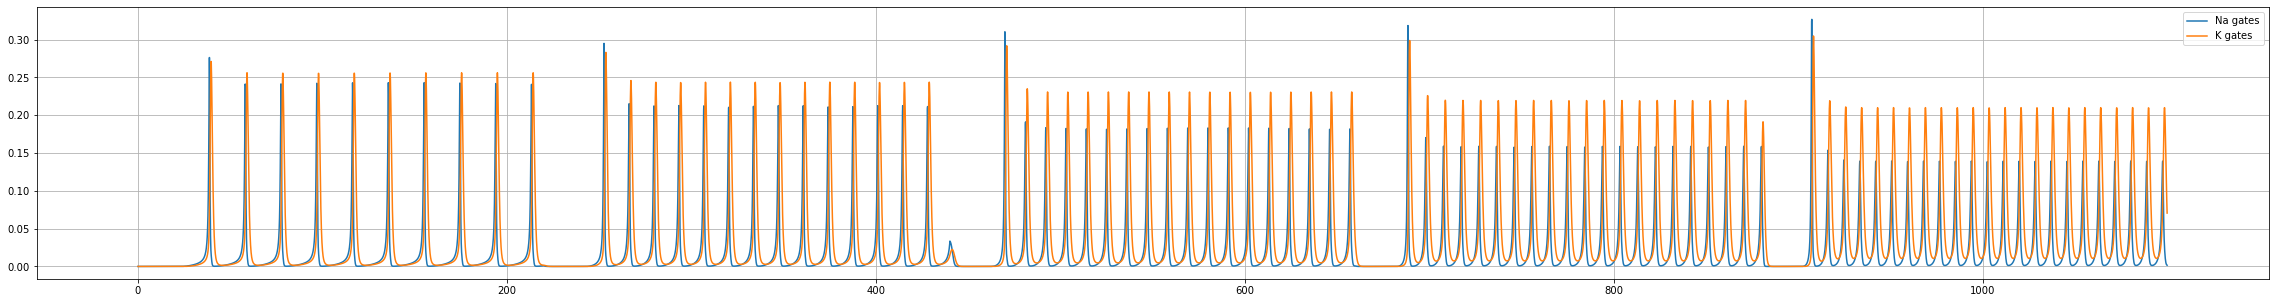

In [151]:
figure(figsize=(40,5))
plot(min_mon.t/ms, min_mon.m[0]**3 * min_mon.h[0], label="Na gates")
plot(min_mon.t/ms, min_mon.n[0]**4, label="K gates")
legend()
grid()

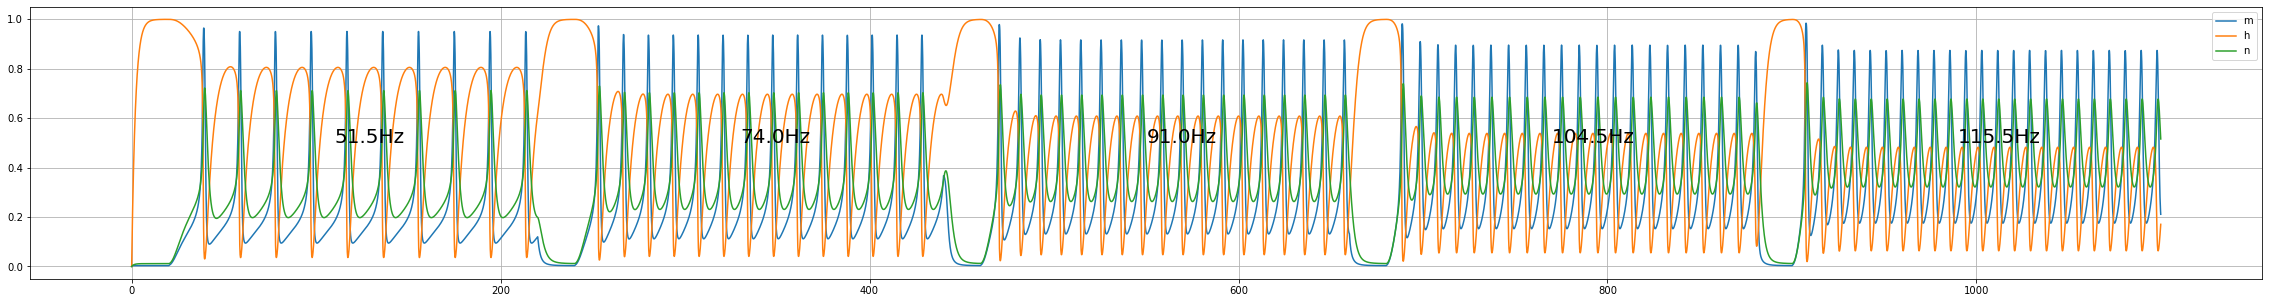

In [145]:
figure(figsize=(40, 5))
plot(min_mon.t/ms, min_mon.m[0], label="m")
plot(min_mon.t/ms, min_mon.h[0], label="h")
plot(min_mon.t/ms, min_mon.n[0], label="n")
legend()
grid()
for i in range(len(currents)):
    text(110+220*i, 0.5, str(if_min_frequencies[i*5+42])+'Hz', fontsize=20)

# Тестим добавлние Нав18 (на удачу)

In [149]:
eqs

dv/dt = (I + gK*n**4*(Ek - v) + gL*(El - v) + gNa*h*m**3*(Ena - v))/Cm : volt
I : amp


In [150]:
print(eqs)

dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + I) / Cm : V
I : A


In [13]:
_gNa18 = 100*nS
gNa = 75*nS

gNa18_eq = Equations("""
INa18 = _gNa18 * m**3 * h * (v - Ena) : ampere

alpha_m = 2.85/ms - 2.84 / (1 + exp((v/mV - 1.16)/13.95)) / ms : Hz
beta_m = 7.62 / (1 + exp((v/mV + 46.5)/8.83)) / ms : Hz
m_inf = alpha_m / (alpha_m + beta_m) : 1
tau_m = 1 / (alpha_m + beta_m) : second
dm/dt = (m_inf - m) / tau_m : 1

tau_h = 1.218*ms + 42. * exp(-((v/mV + 38.1)**2) / (2*15.2**2))*ms : second
h_inf = 1 / (1 + exp((v/mV + 32.2)/4)) : 1
dh/dt = (h_inf - h) / tau_h : 1
""",
    m="mNa18", h="hNa18",
    alpha_m="amNa18", beta_m="bmNa18", tau_m="tau_mNa18", m_inf="mNa18_inf",
    tau_h="tau_hNa18", h_inf="hNa18_inf"
)

base_nav18 = Equations(
    """
    dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + INa18 + I) / Cm : volt
    I : ampere
    """)

nav18_eqs = base_nav18 + dndt + dhdt + dmdt + gNa18_eq

In [14]:
start_scope()
nav18_neuron = NeuronGroup(1, nav18_eqs, method='euler')
nav18_mon = StateMonitor(nav18_neuron, ["v", "mNa18", "hNa18"], True)

currents = np.arange(100.8, 160, 2.4*5) * pA
for cur in currents:
    run(20*ms)
    nav18_neuron.I = cur
    run(500*ms)
    nav18_neuron.I = 0*pA

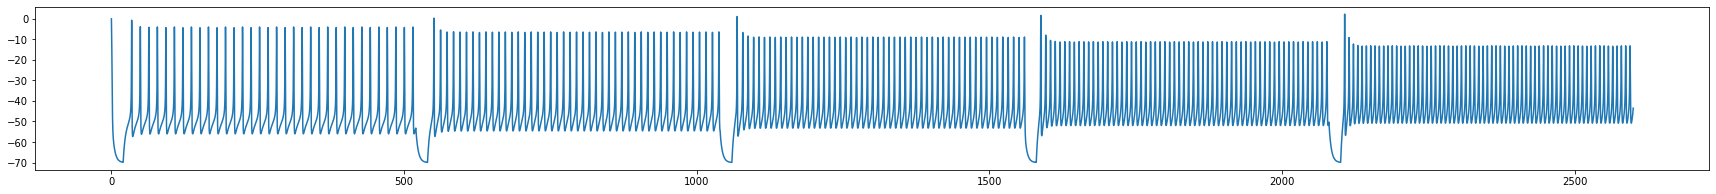

In [186]:
figure(figsize=(30,3))
plot(nav18_mon.t/ms, nav18_mon.v[0]/mV)

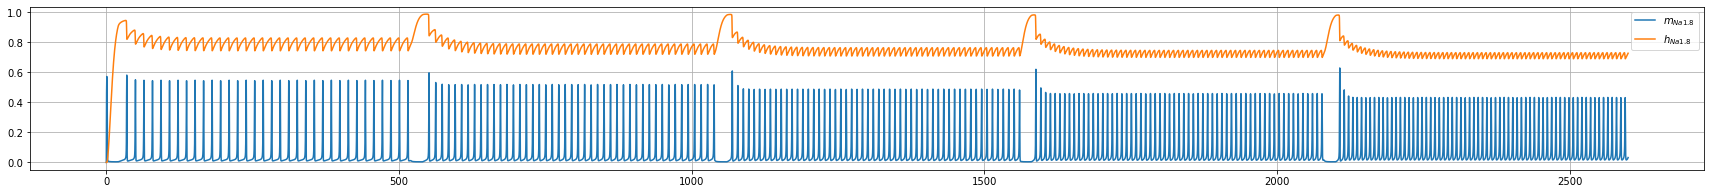

In [187]:
figure(figsize=(30,3))
plot(nav18_mon.t/ms, nav18_mon.mNa18[0], label="$m_{Na1.8}$")
plot(nav18_mon.t/ms, nav18_mon.hNa18[0], label="$h_{Na1.8}$")
legend()
grid()

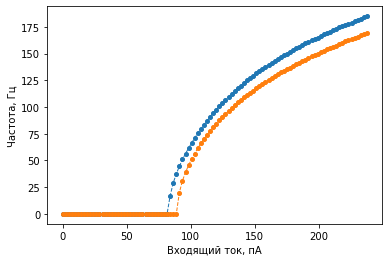

In [188]:
start_scope()
nav18_neuron = NeuronGroup(100, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method='exponential_euler')
nav18_spikemon = compIFcurve(nav18_neuron)
plotIFcurve(nav18_spikemon, nav18_neuron)
plotIFcurve(min_mon, if_min_group)

WARNING    'i' is an internal variable of group 'neurongroup_12', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


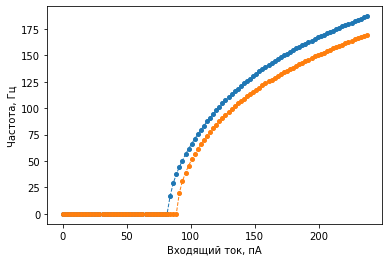

In [191]:
start_scope()
nav18_neuron = NeuronGroup(100, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method='exponential_euler')
nav18_spikemon = compIFcurve(nav18_neuron)
plotIFcurve(nav18_spikemon, nav18_neuron)
plotIFcurve(min_mon, if_min_group)

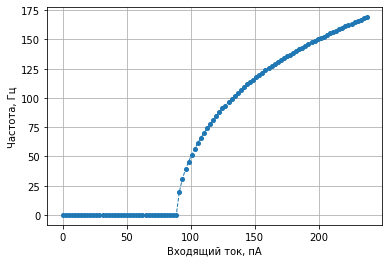

In [ ]:
plotIFcurve(min_mon, if_min_group)

## Добавлю Нав1.8 к повышенной утечке

### High $g_l$ and minimal equations

In [11]:
start_scope()
highgl = 7.5*nS
highEl_group = NeuronGroup(N, min_eqs, method="euler", namespace={"gL": highgl},
                           threshold=threshold_str, refractory=refractory_str)

### Low $g_l$ and minimal equations

WARNING    'i' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_5". Will use the object from the group-specific namespace with the value 3. * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


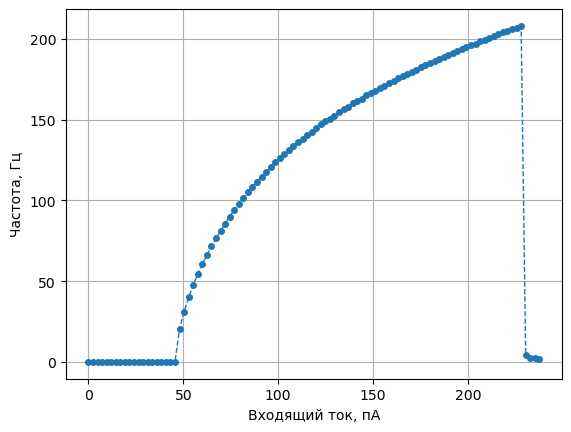

In [12]:
start_scope()
lowGl = 3. *nS
lowEl_neuron = NeuronGroup(N, min_eqs, method="euler", namespace={"gL": lowGl},
                           threshold=threshold_str, refractory=refractory_str)
lowEl_spikemon = compIFcurve(lowEl_neuron)
plotIFcurve(lowEl_spikemon, lowEl_neuron)

### Low $g_l$ and nav18 equations

WARNING    'i' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_6". Will use the object from the group-specific namespace with the value 3. * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gNa" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_6". Will use the object from the group-specific namespace with the value 20. * nsiemens, but the name also refers to a variable in the run namespace with value '75. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


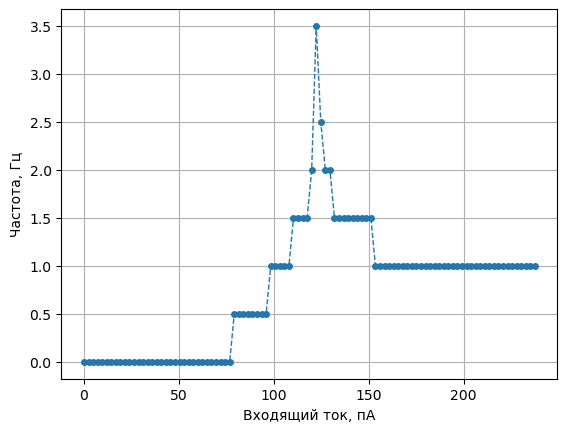

In [13]:
start_scope()
lowgl_nav18_neuron = NeuronGroup(N, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method='exponential_euler', namespace={"gL": lowGl,
                                                                                                                                          "gNa18": 20*nS,
                                                                                                                                          "gNa": 20*nS})
lowgl_nav18_spikemon = compIFcurve(lowgl_nav18_neuron)
plotIFcurve(lowgl_nav18_spikemon, lowgl_nav18_neuron)


#### Loop through the **gNa == gNa18** values (low gL)

WARNING    'i' is an internal variable of group 'neurongroup_8', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_8". Will use the object from the group-specific namespace with the value 3. * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


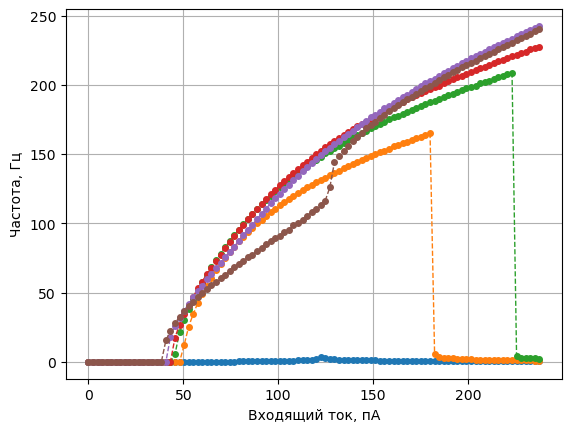

In [15]:
start_scope()
lowgl_nav18_neuron = NeuronGroup(N, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                 namespace={"gL": lowGl})
gNas = [20, 50, 80, 100, 150, 200] * nS
for gNa in gNas:
    lowgl_nav18_neuron.namespace['gNa'] = gNa
    lowgl_nav18_neuron.namespace['gNa18'] = gNa
    lowgl_nav18_spikemon = compIFcurve(lowgl_nav18_neuron)
    plotIFcurve(lowgl_nav18_spikemon, lowgl_nav18_neuron)

#### Loop gNa18 with fixed gNa == 20nS

WARNING    The name "gNa" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_8". Will use the object from the group-specific namespace with the value 20. * nsiemens, but the name also refers to a variable in the run namespace with value '200. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


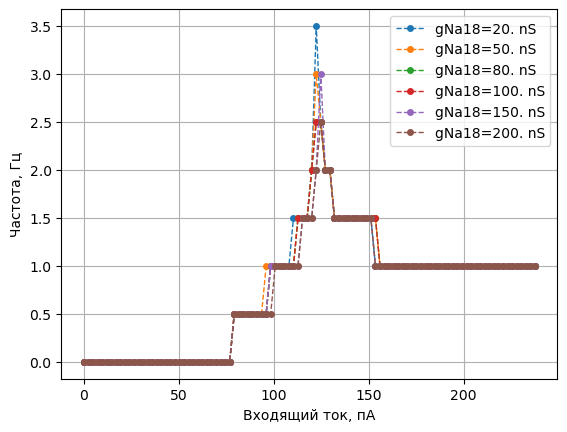

In [17]:
start_scope()
lowgl_nav18_neuron = NeuronGroup(N, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                 namespace={"gL": lowGl,
                                            "gNa": 20*nS})  # FIXED CONDUCTANCE
gNas = [20, 50, 80, 100, 150, 200] * nS 
for gNa18 in gNas:
    lowgl_nav18_neuron.namespace['gNa18'] = gNa18
    lowgl_nav18_spikemon = compIFcurve(lowgl_nav18_neuron)
    plotIFcurve(lowgl_nav18_spikemon, lowgl_nav18_neuron)
legend([f"gNa18={gNa18}" for gNa18 in gNas])

#### Loop gNa18 with fixed gNa==50nS

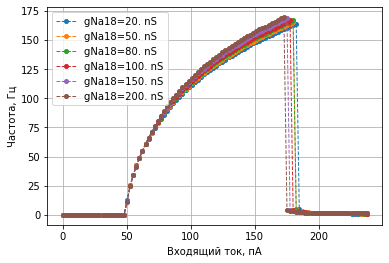

In [61]:
start_scope()
lowgl_nav18_neuron = NeuronGroup(N, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                 namespace={"gL": lowGl,
                                            "gNa": 50*nS})  # FIXED CONDUCTANCE
gNas = [20, 50, 80, 100, 150, 200] * nS 
for gNa18 in gNas:
    lowgl_nav18_neuron.namespace['gNa18'] = gNa18
    lowgl_nav18_spikemon = compIFcurve(lowgl_nav18_neuron)
    plotIFcurve(lowgl_nav18_spikemon, lowgl_nav18_neuron)
legend([f"gNa18={gNa18}" for gNa18 in gNas])

#### Loop gNa with fixed gNa18==50nS

WARNING    The name "gNa18" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_9". Will use the object from the group-specific namespace with the value 50. * nsiemens, but the name also refers to a variable in the run namespace with value '200. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


CPU times: user 8min 53s, sys: 2.77 s, total: 8min 56s
Wall time: 8min 59s


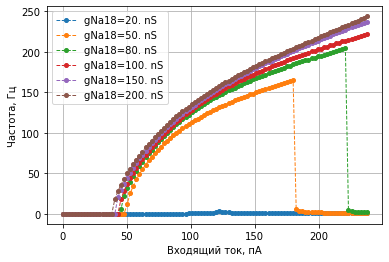

In [62]:
%%time
start_scope()
lowgl_nav18_neuron = NeuronGroup(N, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                 namespace={"gL": lowGl,
                                            "gNa18": 50*nS})  # FIXED CONDUCTANCE
gNas = [20, 50, 80, 100, 150, 200] * nS 
for gNa in gNas:
    lowgl_nav18_neuron.namespace['gNa'] = gNa
    lowgl_nav18_spikemon = compIFcurve(lowgl_nav18_neuron)
    plotIFcurve(lowgl_nav18_spikemon, lowgl_nav18_neuron)
legend([f"gNa18={gNa18}" for gNa18 in gNas])

#### min vs. nav18 equations

In [66]:
start_scope()
lowgl_nav18_neuron = NeuronGroup(N, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                 namespace={"gL": lowGl,
                                            "gNa": 100*nS})
lowgl_min_neuron = NeuronGroup(N, min_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                               namespace={"gL": lowGl,
                                          "gNa": 100*nS})
lowgl_nav18_neuron.namespace["gNa18"] = 200*nS
lowgl_nav18_spikemon1 = compIFcurve(lowgl_nav18_neuron)
lowgl_nav18_neuron.namespace["gNa18"] = 70*nS
lowgl_nav18Pspikemon2 = compIFcurve(lowgl_nav18_neuron)
lowgl_min_spikemon = compIFcurve(lowgl_min_neuron)
lowgl_min_neuron.namespace["gNa"] = 200*nS
lowgl_min_spikemon2 = compIFcurve(lowgl_min_neuron)

WARNING    The name "gNa18" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_12". Will use the object from the group-specific namespace with the value 200. * nsiemens, but the name also refers to a variable in the run namespace with value '200. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gNa" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_12". Will use the object from the group-specific namespace with the value 100. * nsiemens, but the name also refers to a variable in the run namespace with value '200. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_13". Will use the object from the group-specific namespace with the value 3. * nsiemens, but the name als

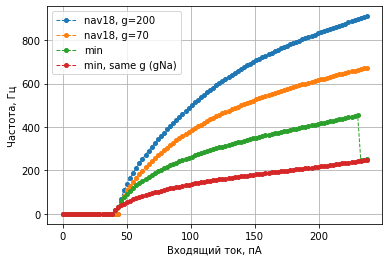

In [67]:
plotIFcurve(lowgl_nav18_spikemon1, lowgl_nav18_neuron)
plotIFcurve(lowgl_nav18spikemon2, lowgl_nav18_neuron)
plotIFcurve(lowgl_min_spikemon, lowgl_min_neuron)
plotIFcurve(lowgl_min_spikemon2, lowgl_min_neuron)
legend(["nav18, g=200", "nav18, g=70", "min", "min, same g (gNa)"])

### low $g_l$, difference between $Na_{v18}$ and minimal equations

In [20]:
print("Nav18")
print(nav18_eqs)
print("Minimal")
print(min_eqs)

Nav18
a_n = 0.032/mV * 5*mV / exprel((15*mV - v + VT)/5/mV) / ms : Hz
b_n = 0.5 * exp((10*mV - v + VT)/40/mV) / ms : Hz
a_m = 0.32/mV * 4*mV / exprel((13*mV - v + VT)/4/mV) / ms : Hz
b_m = 0.28/mV * 5*mV / exprel((v - VT - 40*mV)/5/mV) / ms : Hz
a_h = 0.128*exp((17*mV - v + VT)/18/mV) / ms : Hz
b_h = 4 / (1 + exp((40*mV - v + VT)/5/mV)) / ms : Hz
INa18 = _gNa18 * mNa18**3 * hNa18 * (v - Ena) : A
dh/dt = a_h * (1 - h) - b_h * h : 1
dm/dt = a_m * (1 - m) - b_m * m : 1
dn/dt = a_n * (1 - n) - b_n * n : 1
amNa18 = 2.85/ms - 2.84 / (1 + exp((v/mV - 1.16)/13.95)) / ms : Hz
bmNa18 = 7.62 / (1 + exp((v/mV + 46.5)/8.83)) / ms : Hz
tau_hNa18 = 1.218*ms + 42. * exp(-((v/mV + 38.1)**2) / (2*15.2**2))*ms : s
hNa18_inf = 1 / (1 + exp((v/mV + 32.2)/4)) : 1
mNa18_inf = amNa18 / (amNa18 + bmNa18) : 1
tau_mNa18 = 1 / (amNa18 + bmNa18) : s
dhNa18/dt = (hNa18_inf - hNa18) / tau_hNa18 : 1
dmNa18/dt = (mNa18_inf - mNa18) / tau_mNa18 : 1
dv/dt = (gL * (El - v) + gK * n**4 * (Ek - v) + gNa*m**3*h*(Ena - v) + 

In [22]:
start_scope()

lowGl = 3. *nS

nav18_lowgl_group = NeuronGroup(100, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                namespace={"gL": 3*nS,
                                           "gNa": 50*nS})
nav18_lowgl_group.namespace["gNa18"] = 100*nS
lowgl_group = NeuronGroup(100, min_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                          namespace={"gL": 3*nS,
                                     "gNa": 50*nS})

nav18_lowgl_spikemon = compIFcurve(nav18_lowgl_group)
lowgl_spikemon = compIFcurve(lowgl_group)

WARNING    'i' is an internal variable of group 'neurongroup_7', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_7". Will use the object from the group-specific namespace with the value 3. * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gNa" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_7". Will use the object from the group-specific namespace with the value 50. * nsiemens, but the name also refers to a variable in the run namespace with value '75. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to differen

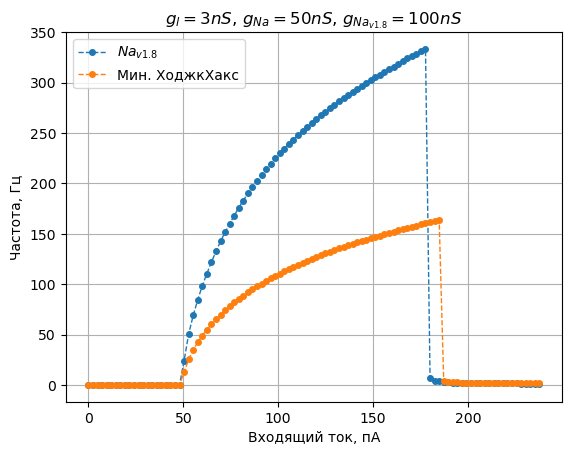

In [28]:
title("$g_l=3nS$, $g_{Na}=50nS$, $g_{Na_{v1.8}}=100nS$")
plotIFcurve(nav18_lowgl_spikemon, nav18_lowgl_group)
plotIFcurve(lowgl_spikemon, lowgl_group)
legend(["$Na_{v1.8}$", "Мин. ХоджкХакс"])
#savefig("images/nav_minimal_ifcurve.jpeg")

In [49]:
def sim_spikes(group: NeuronGroup, currs: list) -> StateMonitor:
    mon = StateMonitor(group, ["v"], 0)
    for cur in currs:
        group.I[0] = cur
        run(100*ms)
        group.I[0] = 0*nA
        run(10*ms)
    return mon

In [66]:
start_scope()
currs = [70*pA, 100*pA, 175*pA]

nav18_lowgl_group = NeuronGroup(100, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                                namespace={"gL": 3*nS,
                                           "gNa": 50*nS})
nav18_lowgl_group.namespace["gNa18"] = 100*nS
nav18_lowgl_group.v = El
nav18_lowgl_statemon = sim_spikes(nav18_lowgl_group, currs)
start_scope()
lowgl_group = NeuronGroup(100, min_eqs, threshold=threshold_str, refractory=refractory_str, method="exponential_euler",
                          namespace={"gL": 3*nS,
                                     "gNa": 50*nS})
lowgl_group.v = El
lowgl_statemon = sim_spikes(lowgl_group, currs)

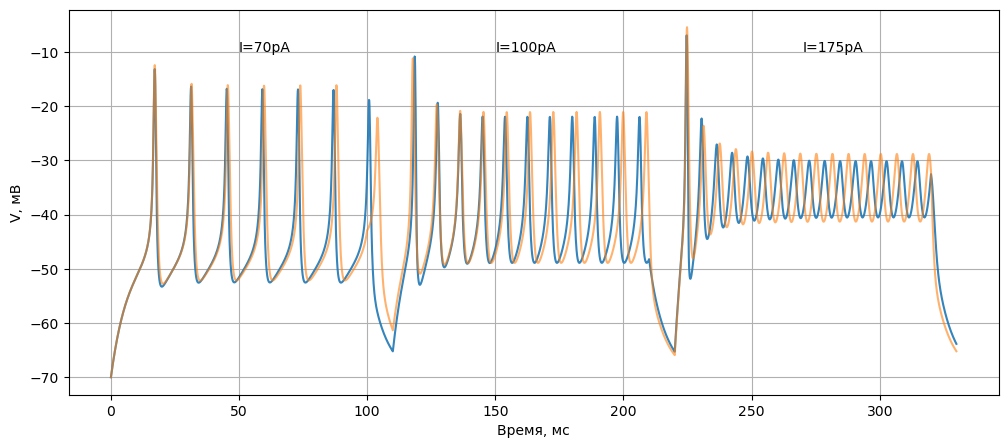

In [74]:
figure(figsize=(12, 5))
plot(nav18_lowgl_statemon.t/ms, nav18_lowgl_statemon.v[0]/mV, alpha=.9)
plot(lowgl_statemon.t/ms, lowgl_statemon.v[0]/mV, alpha=.6)
grid()
xlabel("Время, мс")
ylabel("V, мВ")
text(50, -10, "I=70pA")
text(150, -10, "I=100pA")
text(270, -10, "I=175pA")
#savefig("images/nav_minimal_spikes.jpeg", dpi=150)

#### Vary gK

In [ ]:
start_scope()

### High $g_l$ and nav18 equations

WARNING    'i' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "gL" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_6". Will use the object from the group-specific namespace with the value 7.5 * nsiemens, but the name also refers to a variable in the run namespace with value '5. * nsiemens'. [brian2.groups.group.Group.resolve.resolution_conflict]


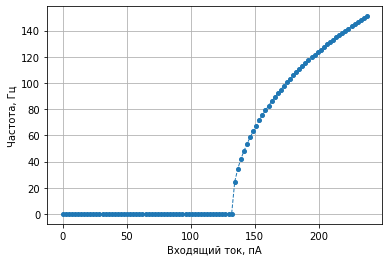

In [16]:
start_scope()

nav18_lowEl_neuron = NeuronGroup(100, nav18_eqs, threshold=threshold_str, refractory=refractory_str, method='exponential_euler', namespace={"gL":highgl})
nav18_lowEl_spikemon = compIFcurve(nav18_lowEl_neuron)
plotIFcurve(nav18_lowEl_spikemon, nav18_lowEl_neuron)
#plotIFcurve(min_mon, if_min_group)

### Общая сводка

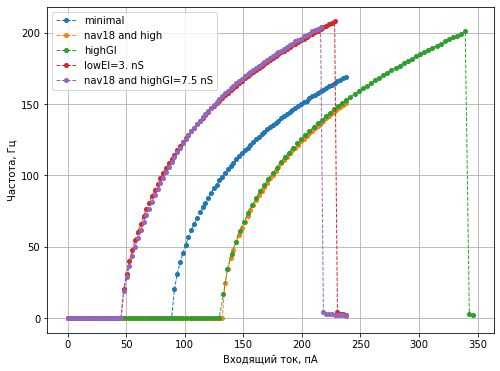

In [43]:
# Nav1.8 - and lowEl
figure(figsize=(8, 6))
plotIFcurve(min_mon, if_min_group)
plotIFcurve(nav18_lowEl_spikemon, nav18_lowEl_neuron)
plotIFcurve(highEl_mon, highEl_group)
plotIFcurve(lowEl_spikemon, lowEl_neuron)
plotIFcurve(lowgl_nav18_spikemon, lowgl_nav18_neuron)

legend(['minimal', 'nav18 and high', "highGl", f"lowEl={lowGl}", f"nav18 and highGl={highgl}"])

- отрицательное сопротивление
- генерация сигнала
- хотим увидеть "высокочастотную" составляющую (от одного типа каналов)
    - А что, если нужны и калиевые каналы, которые "помогают" натриевым
- Концепция "отрицательного сопротивления" в рамках нейронов:
    - входящий ток (синапсы или просто ввод) приводит к увеличению проводимости каналов
- Почему вообще такая характеристика нейронов? Отрицательное ускорение кривой
    - 
- С другой стороны, как будто, чтобы поправить картину по частотам надо работать с временными характеристиками
    - ...
    - гипотеза: из-за временных констант - нет места для 

Я вчера немного отошёл от этого всего, занимался тестированием влияния проводимости натриевых каналов. \
Я пытаюсь перебирать проводимости, фиксируя одну их них.